In [6]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from itertools import cycle
from PIL import Image
import numpy as np
import pandas as pd
import pickle
import os
import copy

np.random.seed(1)

In [7]:
EPSILON = 1e-5
# Load GTSDB validation images
CLASSES = ['prohibitory','mandatory','danger']
#Path to the German Traffic Sign Detection Benchmark dataset
DATASET_PATH = '~/content'
full_set = ['%05d.jpg' % x for x in range(900)]
valid_set = full_set[600:900]

In [8]:
category_index = {1: {'id': 1, 'name': 'prohibitory'},
 2: {'id': 2, 'name': 'mandatory'},
 3: {'id': 3, 'name': 'danger'}}
categories = [{'id': 1, 'name': 'prohibitory'},
 {'id': 2, 'name': 'mandatory'},
 {'id': 3, 'name': 'danger'}]

In [9]:
MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous'
# MODEL_NAME = 'faster_rcnn_resnet_101'
# MODEL_NAME = 'faster_rcnn_resnet50'
# MODEL_NAME = 'ssd_inception_v2'
# MODEL_NAME = 'ssd_mobilenet_v1'

In [10]:
MODEL_PATH = os.path.join('models', MODEL_NAME)
with open(os.path.join( 'detections_output_result.pkl'), 'rb') as pickle_file:
    detections = pickle.load(pickle_file)

In [11]:
def filter_val_detections(detections):
    fdetects = []
    for d in detections:
        if d['file'] in valid_set:
            fdetects.append(d)
    return fdetects

In [12]:
def filter_detections_by_width(detections, min_w, max_w):
    fdetects = []
    n_gt_bboxes = 0
    for d in detections:
        d_aux = copy.deepcopy(d)
        j = 0
        for i, bbox in enumerate(d['gt_bboxes']):
            w = bbox[2] - bbox[0]
            if w < min_w or w >= max_w:
                d_aux['gt_bboxes'].pop(i - j)
                d_aux['gt_classes'].pop(i - j)
                try:
                    d_aux['pred_bboxes'].pop(i - j)
                    d_aux['pred_classes'].pop(i - j)
                    d_aux['confidences'].pop(i - j)
                except IndexError:
                    print('Pred bbox num {} of image {} was not removed'.format(i,d_aux['file']))
                j += 1 
        n_gt_bboxes += len(d_aux['gt_bboxes'])
        fdetects.append(d_aux)
    print(n_gt_bboxes)
    return fdetects

In [13]:
def get_detection_by_filename(detections, filename):
    for detection in detections:
        if detection['file'] == filename:
            return detection

In [14]:
def plot_rectangle(bbox,ax,class_name,edgecolor,confidence=None):
    xmin = bbox[0]
    ymin = bbox[1]
    xmax = bbox[2]
    ymax = bbox[3]
    left = xmin
    right = xmax
    top = ymin
    bot = ymax
    ax.add_patch(
        plt.Rectangle((left, top),
                      right-left,
                      bot-top, fill=False,
                      edgecolor=edgecolor, linewidth=2)
        )
    label = '{:s}:'.format(class_name)
    label += ' {0:.2f}%'.format(confidence)
    label_pos_y = ((bot - top) / 2) + top + 3.5
    label_pos_x = right+10
    if class_name == 'danger':
        label_pos_x = left
        label_pos_y = top - 9
    elif class_name == 'prohibitory':
        label_pos_x = left - 30
        label_pos_y = bot + 15
    ax.text(label_pos_x, label_pos_y,label,
            bbox=dict(facecolor=edgecolor, edgecolor=edgecolor, alpha=1),
            fontsize=11)

In [15]:
CLASSES_COLOR = ['DarkOrange','Aqua','Chartreuse']
def plot_dets(detection, model_name):
    fig, ax = plt.subplots(figsize=(20, 20))
    image = np.array(Image.open(detection['file_path']))
    image = np.squeeze(image)
    imWidth = image.shape[1]
    imHeight = image.shape[0]
    for j in range(len(detection['pred_bboxes'])):
        pred_class = detection['pred_classes'][j]
        bbox = detection['pred_bboxes'][j]
        confidence = detection['confidences'][j] * 100
        plot_rectangle(bbox,ax,category_index[pred_class]['name'],CLASSES_COLOR[pred_class-1], confidence)
    plt.axis('off')
    ax.imshow(image, aspect='equal')

In [16]:
def intersection(bbgt, bb):
    # determine the (x, y)-coordinates of the intersection rectangle
    ixmin = max(bbgt[0], bb[0])
    iymin = max(bbgt[1], bb[1])
    ixmax = min(bbgt[2], bb[2])
    iymax = min(bbgt[3], bb[3])
    
    # compute the area of intersection rectangle
    iw = max(ixmax - ixmin, 0)
    ih = max(iymax - iymin, 0)
    intersArea = iw * ih
    
    return intersArea

In [ ]:
def union(bbgt, bb, intersArea):
    # compute the area of both the prediction and ground-truth rectangles
    boxgtArea = (bbgt[2] - bbgt[0]) * (bbgt[3] - bbgt[1])
    boxArea = (bb[2] - bb[0]) * (bb[3] - bb[1])
    unionArea = boxgtArea + boxArea - intersArea
    return unionArea

In [ ]:
# Returns the intersection over union of two rectangles, a and b, where each is an array [x,y,w,h]
def compute_iou(bbgt, bb):
    overlaps = np.zeros(len(bbgt))
    for i,gtBbox in enumerate(bbgt):
        inters = float(intersection(gtBbox, bb))
        uni = union(gtBbox, bb, inters)
        iou = inters/uni
        overlaps[i] = iou
    ioumax = np.max(overlaps)
    jmax = np.argmax(overlaps)
    return ioumax, jmax

In [ ]:
def naive_ap_calculation(rec,prec):
    """
    Take sum of P(k) * \Delta recall(k)
    """
    deltaRecall = []
    rec = np.insert(rec,0,0)
    for i in range(1,rec.shape[0]):
        deltaRecall.append( rec[i] - rec[i-1] ) # find differences
    deltaRecall = np.array(deltaRecall)
    ap = np.dot( deltaRecall,prec)
    return ap

In [ ]:
def voc_ap(rec, prec, use_07_metric=False):
    """ ap = voc_ap(rec, prec, [use_07_metric])
    Compute VOC AP given precision and recall.
    If use_07_metric is true, uses the
    VOC 07 11 point method (default:False).
    """
    if use_07_metric:
        # 11 point metric
        # http://host.robots.ox.ac.uk/pascal/VOC/pubs/everingham10.pdf (page 313)
        
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap = ap + p / 11.
    else:
        # correct AP calculation (from VOC 2010 challenge)
        # http://host.robots.ox.ac.uk/pascal/VOC/voc2012/devkit_doc.pdf (page 12)
        
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))

        # compute the precision envelope
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

        # to calculate area under PR curve, look for points
        # where X axis (recall) changes value
        i = np.where(mrec[1:] != mrec[:-1])[0]

        # and sum (\Delta recall) * prec
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

In [ ]:
def match_gts_and_compute_prec_recall_ap(cls,detections,iouthresh=0.5):
    """
    INPUTS:
    -BB: predicted bounding boxes
    -BBGT: predicted bounding boxes, BBGT = R['bbox'].astype(float)
    OUTPUTS:
    -rec: recall
    -prec: precision
    -ap: average precision
    A bounding box reported by an algorithm is considered
    correct if its area intersection over union with a ground 
    truth bounding box is beyond 50%. If a lot of closely overlapping 
    bounding boxes hitting on a same ground truth, only one of
    them is counted as correct, and all the others are treated as false alarms
    """
    print('IoU threshold set to: {:.2f}'.format(iouthresh))
    GT_OBJECTS = {}
    BB = []
    BB_im_ids = []
    BB_confidences = []
    n_gt_bboxes = 0
    
    for dId,d in enumerate(detections):
        BBGT = []
        for i in range(len(d['gt_bboxes'])):
            if d['gt_classes'][i] == cls:
                BBGT.append(d['gt_bboxes'][i])
                n_gt_bboxes += 1
        GT_OBJECTS[d['file']] = {
            'bboxes' : np.asarray(BBGT),
            'detected?' : [False] * len(BBGT)
        }
        for i in range(len(d['pred_bboxes'])):
            if d['pred_classes'][i] == cls:
                BB.append(d['pred_bboxes'][i])
                BB_im_ids.append(d['file'])
                BB_confidences.append(d['confidences'][i])
      
    if n_gt_bboxes == 0:
        return None,None,None
    
    BB = np.asarray(BB)
    BB_confidences = np.asarray(BB_confidences)
    
    # sort by confidence
    if len(BB) > 0:
        sorted_ind = np.argsort(-BB_confidences)
        sorted_scores = np.sort(-BB_confidences)
        BB = BB[sorted_ind, :]
        BB_im_ids = [BB_im_ids[x] for x in sorted_ind]            
    
    num_detections = len(BB_im_ids)
    tp = np.zeros(num_detections)
    fp = np.zeros(num_detections)
    avg_overlap = []
    
    for d in range(num_detections):
        gt_info = GT_OBJECTS[BB_im_ids[d]]
        bb = BB[d, :].astype(float)
        BBGT = gt_info['bboxes'].astype(float)
        ioumax = -np.inf
        
        if BBGT.size > 0:
            # compute intersection over union
            ioumax, jmax = compute_iou(BBGT,bb)
        if ioumax > iouthresh:
            if not gt_info['detected?'][jmax]:
                tp[d] = 1. # true positive
                gt_info['detected?'][jmax] = 1
                avg_overlap.append(ioumax)
            else:
                fp[d] = 1. # false positive (multiple detection)
        else:
            fp[d] = 1. # false positive
        
    avg_overlap = np.array(avg_overlap) if len(avg_overlap) > 0 else np.array([0])
    
    # compute precision recall
    fp = np.cumsum(fp) if len(fp) > 0 else np.array([0])
    tp = np.cumsum(tp) if len(tp) > 0 else np.array([0])
    
    fn = n_gt_bboxes - tp[-1]
    
    rec = tp / np.maximum(tp + fn, np.finfo(np.float64).eps)
    # avoid divide by zero in case the first detection matches a difficult ground truth
    prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
    
    ap = voc_ap(rec, prec)
    
    print("TP: {}".format(tp[-1]))
    print("FP: {}".format(fp[-1]))
    print("FN: {}".format(fn))
    class_name = category_index[cls]['name']
    print('Avg. overlap for {} = {:.4f}'.format(class_name, np.mean(avg_overlap)))
    
    print('Precision for {} = {:.4f}'.format(class_name, prec[-1]))
    print('Recall for {} = {:.4f}'.format(class_name, rec[-1]))
    
    return rec, prec, ap

In [ ]:
def plot_precision_recall(prec, recall, ap):
    # first append sentinel values at the end
    mrec = np.concatenate(([0.], recall, [recall[-1]]))
    mpre = np.concatenate(([prec[0]], prec, [0.]))
    # Plot Precision-Recall curve
    plt.clf()
    plt.plot(mrec, mpre, lw=2, color='navy',
             label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall: AP={0:0.2f}'.format(ap))
    plt.legend(loc="lower left")
    plt.show()

In [ ]:
def plot_full_precision_recall(data):
    fig, ax = plt.subplots(figsize=(6, 4))
    lines = ["-","--","-.",":"]
    linecycler = cycle(lines)
    for d in data:
        recall = d['recall']
        prec = d['precision']
        ap = d['ap']
        cls = d['class']
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], recall, [recall[-1]]))
        mpre = np.concatenate(([prec[0]], prec, [0.]))
        ax.plot(mrec, mpre, next(linecycler), label='{} (AP = {:.2f}%)'.format(cls,ap*100))
        
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc="lower left")
    plt.draw()
    plt.tight_layout()
    plt.savefig('gtsdb_pre_rec_curves.pdf', format='pdf')
    plt.show()
    plt.clf()

In [ ]:
def compute_mean_average_precision(detections):
    """
    INPUTS:
    -detections: python list of objects with fields: class_given_obj, confidences, bboxes
    OUTPUTS:
    -mAP: float
    For each class, we compute average precision (AP)
    This score corresponds to the area under the precision-recall curve.
    The mean of these numbers is the mAP.
    """
    
    results = []
    plot_data = []

#     plotDets(detections)
    aps = []
    
    for category in categories:
        class_name = category['name']
        rec, prec, ap = match_gts_and_compute_prec_recall_ap(category['id'],detections,iouthresh=0.5)
        
        if rec is None:
            continue
        results.append({'class' : class_name, 'precision' : prec[-1], 'recall' : rec[-1], 'ap' : ap})
        plot_data.append({'class' : class_name, 'precision' : prec, 'recall' : rec, 'ap' : ap})
        if ap is not None:
            aps += [ap]
            print('AP for {} = {:.4f}'.format(class_name, ap))
        plot_precision_recall(prec, rec, ap)
    print('Mean AP = {:.4f}'.format(np.mean(aps)))
    print('~~~~~~~~')
    print('Results:')
    mAP = np.mean(aps)
    df = pd.DataFrame.from_records(results, columns=('class', 'precision', 'recall', 'ap'))
    print(df)
    plot_full_precision_recall(plot_data)
    return mAP

In [ ]:
def compute_mean_average_precision_COCO2016(detections):
    """
    INPUTS:
    -detections: python list of objects with fields: class_given_obj, confidences, bboxes
    OUTPUTS:
    -mAP: float
    For each class, we compute average precision (AP)
    This score corresponds to the area under the precision-recall curve.
    The mean of these numbers is the mAP.
    """

#     plotDets(detections)
    aps_class = []
    for category in categories:
        aps_iou = []
        for iouthresh in np.arange(.5, 1, .05):
            rec, prec, ap = match_gts_and_compute_prec_recall_ap(category['id'],detections,iouthresh)
            if ap is not None:
                aps_iou += [ap]
                print('AP for {} and IoU threshold {:.2f} = {:.4f}'.format(category['name'], iouthresh, ap))
            plot_precision_recall(prec, rec, ap)
        aps_class += [np.mean(aps_iou)] 
        print('Mean AP for {} = {:.4f}'.format(category['name'],np.mean(aps_iou)))
        
    print('Mean AP = {:.4f}'.format(np.mean(aps_class)))
    print('~~~~~~~~')
    print('Results:')
    for ap in aps_class:
        print('{:.3f}'.format(ap))
    print('{:.3f}'.format(np.mean(aps_class)))
    mAP = np.mean(aps_class)
    return mAP

In [ ]:
# Filter detections that belong to validation images
detections = filter_val_detections(detections)

In [ ]:
# (0,32) (32,46) (46,1000)
detections_small = filter_detections_by_width(detections, 0, 32)
detections_medium = filter_detections_by_width(detections, 32, 46)
detections_large = filter_detections_by_width(detections, 46, 1000)

Pred bbox num 0 of image 00639.jpg was not removed
89
Pred bbox num 0 of image 00639.jpg was not removed
Pred bbox num 0 of image 00650.jpg was not removed
Pred bbox num 1 of image 00787.jpg was not removed
Pred bbox num 0 of image 00864.jpg was not removed
Pred bbox num 0 of image 00868.jpg was not removed
Pred bbox num 1 of image 00868.jpg was not removed
93
Pred bbox num 0 of image 00650.jpg was not removed
Pred bbox num 1 of image 00787.jpg was not removed
Pred bbox num 0 of image 00864.jpg was not removed
Pred bbox num 0 of image 00868.jpg was not removed
Pred bbox num 1 of image 00868.jpg was not removed
91


In [ ]:
print(detections[0])

{'file': '00624.jpg', 'file_path': '/media/arcos/Shared/Datasets/GermanTSDataset/Detection/00624.jpg', 'gt_classes': [2, 1], 'pred_bboxes': [(387.6166534423828, 505.2435874938965, 434.12413120269775, 553.7459373474121), (820.5635166168213, 463.40880393981934, 844.9479532241821, 487.5168800354004)], 'pred_classes': [2, 1], 'confidences': [0.99999785, 0.99996483], 'gt_bboxes': [(387, 505, 434, 554), (821, 464, 845, 488)]}


IoU threshold set to: 0.50
TP: 161.0
FP: 5.0
FN: 0.0
Avg. overlap for prohibitory = 0.9137
Precision for prohibitory = 0.9699
Recall for prohibitory = 1.0000
AP for prohibitory = 1.0000


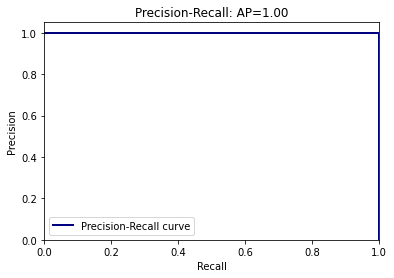

IoU threshold set to: 0.50
TP: 46.0
FP: 12.0
FN: 3.0
Avg. overlap for mandatory = 0.8916
Precision for mandatory = 0.7931
Recall for mandatory = 0.9388
AP for mandatory = 0.9366


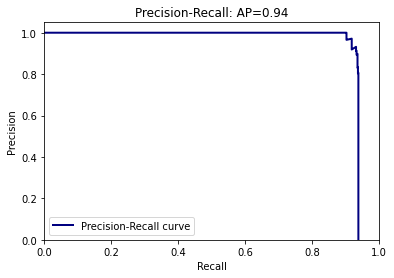

IoU threshold set to: 0.50
TP: 59.0
FP: 5.0
FN: 4.0
Avg. overlap for danger = 0.9011
Precision for danger = 0.9219
Recall for danger = 0.9365
AP for danger = 0.9365


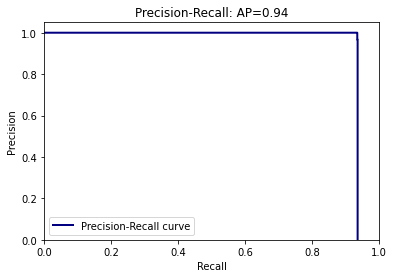

Mean AP = 0.9577
~~~~~~~~
Results:
         class  precision    recall        ap
0  prohibitory   0.969880  1.000000  1.000000
1    mandatory   0.793103  0.938776  0.936559
2       danger   0.921875  0.936508  0.936474


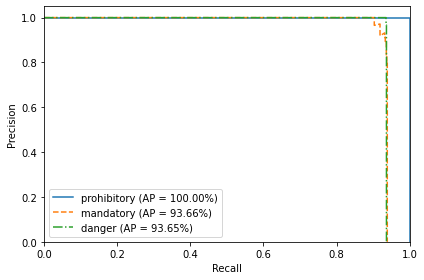

----- Small detections -----
IoU threshold set to: 0.50
TP: 53.0
FP: 9.0
FN: 4.0
Avg. overlap for prohibitory = 0.8872
Precision for prohibitory = 0.8548
Recall for prohibitory = 0.9298
AP for prohibitory = 0.8818


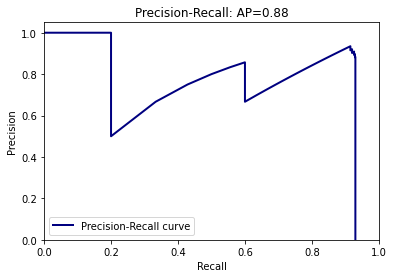

IoU threshold set to: 0.50
TP: 19.0
FP: 12.0
FN: 3.0
Avg. overlap for mandatory = 0.8446
Precision for mandatory = 0.6129
Recall for mandatory = 0.8636
AP for mandatory = 0.8490


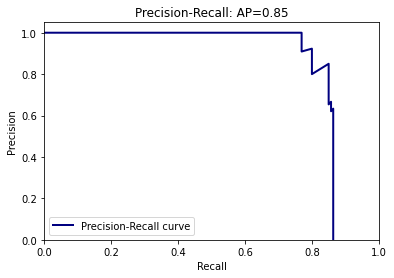

IoU threshold set to: 0.50
TP: 5.0
FP: 7.0
FN: 5.0
Avg. overlap for danger = 0.8175
Precision for danger = 0.4167
Recall for danger = 0.5000
AP for danger = 0.3272


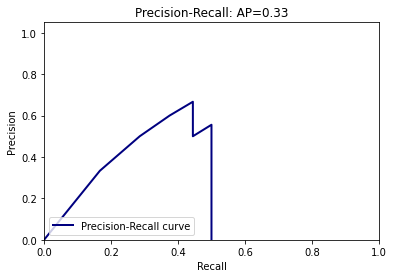

Mean AP = 0.6860
~~~~~~~~
Results:
         class  precision    recall        ap
0  prohibitory   0.854839  0.929825  0.881834
1    mandatory   0.612903  0.863636  0.849008
2       danger   0.416667  0.500000  0.327160


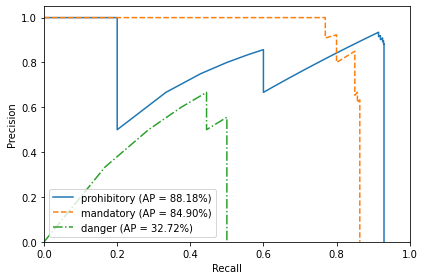

----- Medium detections -----
IoU threshold set to: 0.50
TP: 59.0
FP: 9.0
FN: 5.0
Avg. overlap for prohibitory = 0.9119
Precision for prohibitory = 0.8676
Recall for prohibitory = 0.9219
AP for prohibitory = 0.9184


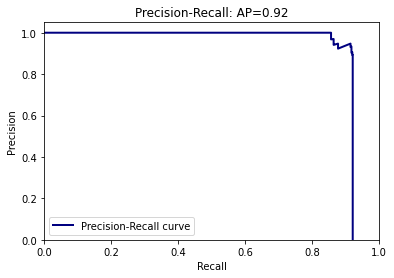

IoU threshold set to: 0.50
TP: 13.0
FP: 11.0
FN: 1.0
Avg. overlap for mandatory = 0.9060
Precision for mandatory = 0.5417
Recall for mandatory = 0.9286
AP for mandatory = 0.9273


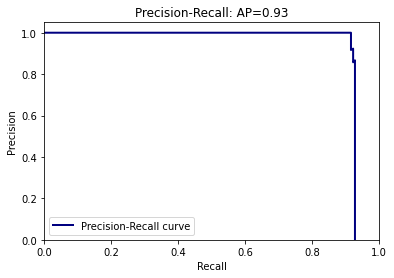

IoU threshold set to: 0.50
TP: 13.0
FP: 9.0
FN: 2.0
Avg. overlap for danger = 0.8812
Precision for danger = 0.5909
Recall for danger = 0.8667
AP for danger = 0.7528


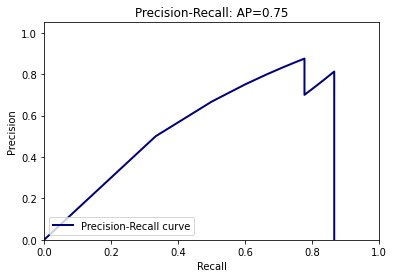

Mean AP = 0.8662
~~~~~~~~
Results:
         class  precision    recall        ap
0  prohibitory   0.867647  0.921875  0.918428
1    mandatory   0.541667  0.928571  0.927346
2       danger   0.590909  0.866667  0.752778


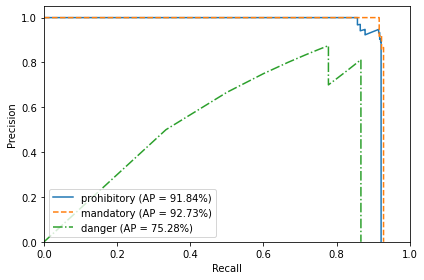

----- Large detections -----
IoU threshold set to: 0.50
TP: 36.0
FP: 10.0
FN: 4.0
Avg. overlap for prohibitory = 0.9474
Precision for prohibitory = 0.7826
Recall for prohibitory = 0.9000
AP for prohibitory = 0.8723


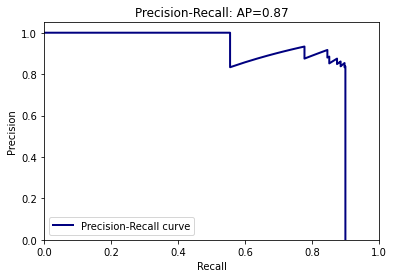

IoU threshold set to: 0.50
TP: 12.0
FP: 13.0
FN: 1.0
Avg. overlap for mandatory = 0.9471
Precision for mandatory = 0.4800
Recall for mandatory = 0.9231
AP for mandatory = 0.6695


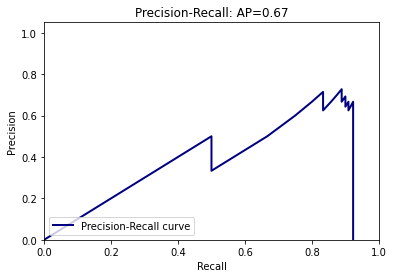

IoU threshold set to: 0.50
TP: 35.0
FP: 5.0
FN: 3.0
Avg. overlap for danger = 0.9199
Precision for danger = 0.8750
Recall for danger = 0.9211
AP for danger = 0.9211


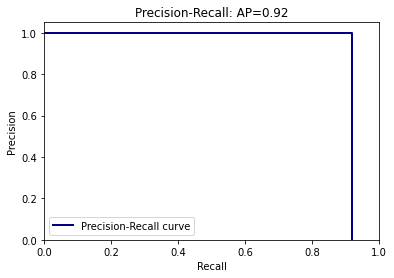

Mean AP = 0.8210
~~~~~~~~
Results:
         class  precision    recall        ap
0  prohibitory   0.782609  0.900000  0.872315
1    mandatory   0.480000  0.923077  0.669542
2       danger   0.875000  0.921053  0.921053


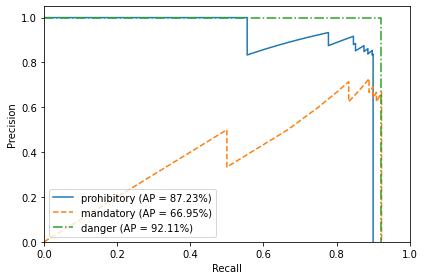

0.8209698449323071

<Figure size 432x288 with 0 Axes>

In [ ]:
compute_mean_average_precision(detections)
print("----- Small detections -----")
compute_mean_average_precision(detections_small)
print("----- Medium detections -----")
compute_mean_average_precision(detections_medium)
print("----- Large detections -----")
compute_mean_average_precision(detections_large)

IoU threshold set to: 0.50
TP: 161.0
FP: 5.0
FN: 0.0
Avg. overlap for prohibitory = 0.9137
Precision for prohibitory = 0.9699
Recall for prohibitory = 1.0000
AP for prohibitory and IoU threshold 0.50 = 1.0000


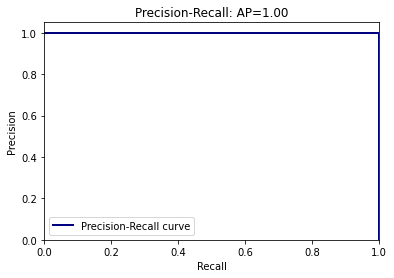

IoU threshold set to: 0.55
TP: 161.0
FP: 5.0
FN: 0.0
Avg. overlap for prohibitory = 0.9137
Precision for prohibitory = 0.9699
Recall for prohibitory = 1.0000
AP for prohibitory and IoU threshold 0.55 = 1.0000


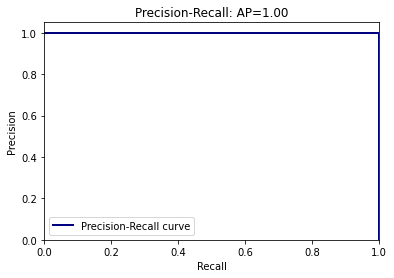

IoU threshold set to: 0.60
TP: 161.0
FP: 5.0
FN: 0.0
Avg. overlap for prohibitory = 0.9137
Precision for prohibitory = 0.9699
Recall for prohibitory = 1.0000
AP for prohibitory and IoU threshold 0.60 = 1.0000


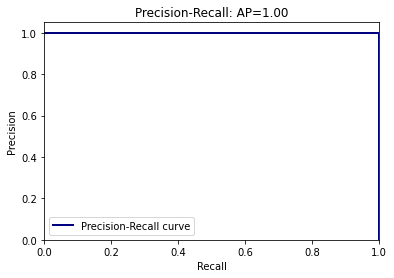

IoU threshold set to: 0.65
TP: 161.0
FP: 5.0
FN: 0.0
Avg. overlap for prohibitory = 0.9137
Precision for prohibitory = 0.9699
Recall for prohibitory = 1.0000
AP for prohibitory and IoU threshold 0.65 = 1.0000


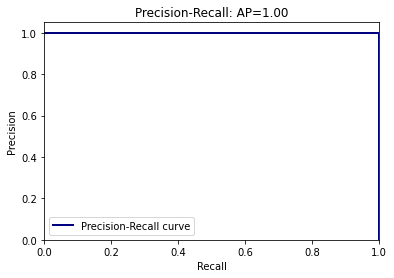

IoU threshold set to: 0.70
TP: 161.0
FP: 5.0
FN: 0.0
Avg. overlap for prohibitory = 0.9137
Precision for prohibitory = 0.9699
Recall for prohibitory = 1.0000
AP for prohibitory and IoU threshold 0.70 = 1.0000


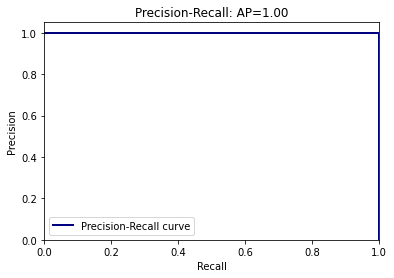

IoU threshold set to: 0.75
TP: 160.0
FP: 6.0
FN: 1.0
Avg. overlap for prohibitory = 0.9147
Precision for prohibitory = 0.9639
Recall for prohibitory = 0.9938
AP for prohibitory and IoU threshold 0.75 = 0.9938


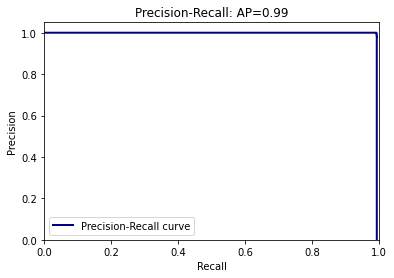

IoU threshold set to: 0.80
TP: 157.0
FP: 9.0
FN: 4.0
Avg. overlap for prohibitory = 0.9174
Precision for prohibitory = 0.9458
Recall for prohibitory = 0.9752
AP for prohibitory and IoU threshold 0.80 = 0.9750


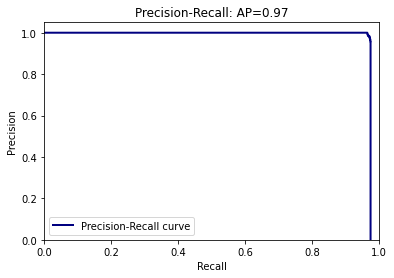

IoU threshold set to: 0.85
TP: 145.0
FP: 21.0
FN: 16.0
Avg. overlap for prohibitory = 0.9253
Precision for prohibitory = 0.8735
Recall for prohibitory = 0.9006
AP for prohibitory and IoU threshold 0.85 = 0.8935


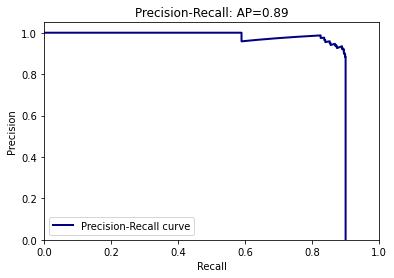

IoU threshold set to: 0.90
TP: 112.0
FP: 54.0
FN: 49.0
Avg. overlap for prohibitory = 0.9375
Precision for prohibitory = 0.6747
Recall for prohibitory = 0.6957
AP for prohibitory and IoU threshold 0.90 = 0.6140


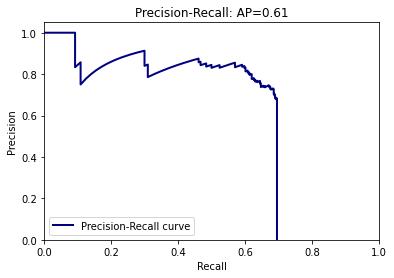

IoU threshold set to: 0.95
TP: 35.0
FP: 131.0
FN: 126.0
Avg. overlap for prohibitory = 0.9622
Precision for prohibitory = 0.2108
Recall for prohibitory = 0.2174
AP for prohibitory and IoU threshold 0.95 = 0.0799


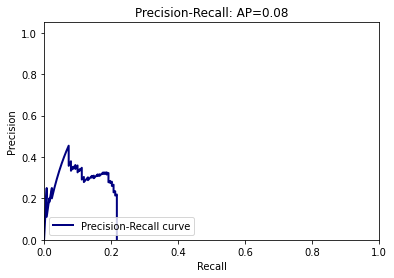

Mean AP for prohibitory = 0.8556
IoU threshold set to: 0.50
TP: 46.0
FP: 12.0
FN: 3.0
Avg. overlap for mandatory = 0.8916
Precision for mandatory = 0.7931
Recall for mandatory = 0.9388
AP for mandatory and IoU threshold 0.50 = 0.9366


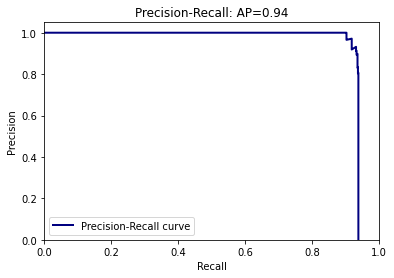

IoU threshold set to: 0.55
TP: 46.0
FP: 12.0
FN: 3.0
Avg. overlap for mandatory = 0.8916
Precision for mandatory = 0.7931
Recall for mandatory = 0.9388
AP for mandatory and IoU threshold 0.55 = 0.9366


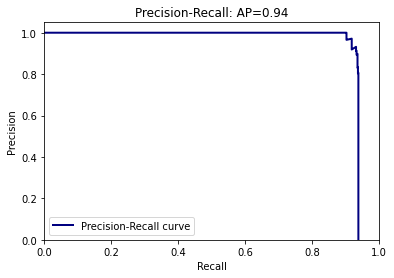

IoU threshold set to: 0.60
TP: 45.0
FP: 13.0
FN: 4.0
Avg. overlap for mandatory = 0.8982
Precision for mandatory = 0.7759
Recall for mandatory = 0.9184
AP for mandatory and IoU threshold 0.60 = 0.9159


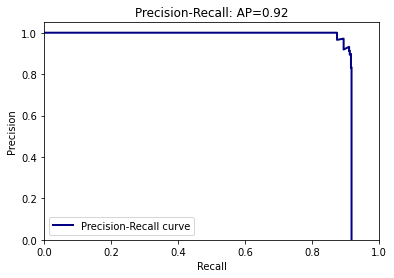

IoU threshold set to: 0.65
TP: 45.0
FP: 13.0
FN: 4.0
Avg. overlap for mandatory = 0.8982
Precision for mandatory = 0.7759
Recall for mandatory = 0.9184
AP for mandatory and IoU threshold 0.65 = 0.9159


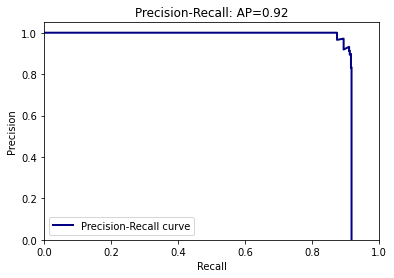

IoU threshold set to: 0.70
TP: 45.0
FP: 13.0
FN: 4.0
Avg. overlap for mandatory = 0.8982
Precision for mandatory = 0.7759
Recall for mandatory = 0.9184
AP for mandatory and IoU threshold 0.70 = 0.9159


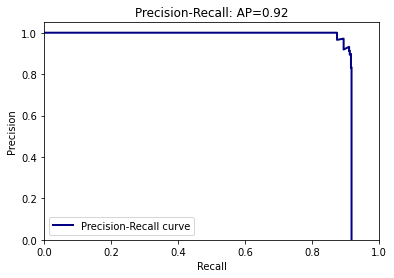

IoU threshold set to: 0.75
TP: 44.0
FP: 14.0
FN: 5.0
Avg. overlap for mandatory = 0.9020
Precision for mandatory = 0.7586
Recall for mandatory = 0.8980
AP for mandatory and IoU threshold 0.75 = 0.8919


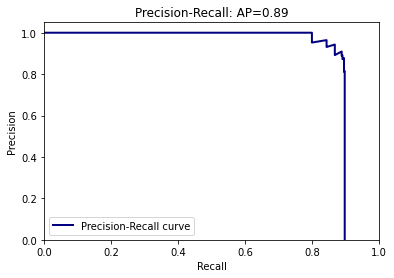

IoU threshold set to: 0.80
TP: 40.0
FP: 18.0
FN: 9.0
Avg. overlap for mandatory = 0.9146
Precision for mandatory = 0.6897
Recall for mandatory = 0.8163
AP for mandatory and IoU threshold 0.80 = 0.7988


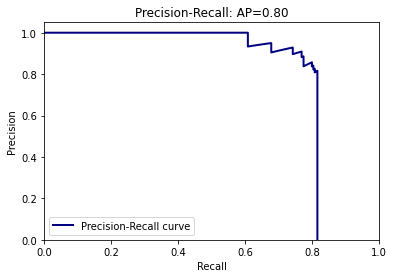

IoU threshold set to: 0.85
TP: 39.0
FP: 19.0
FN: 10.0
Avg. overlap for mandatory = 0.9167
Precision for mandatory = 0.6724
Recall for mandatory = 0.7959
AP for mandatory and IoU threshold 0.85 = 0.7592


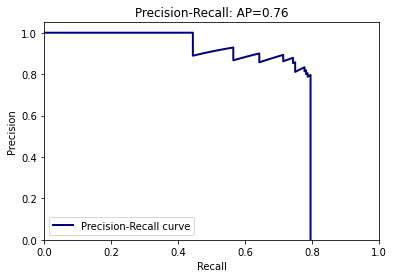

IoU threshold set to: 0.90
TP: 26.0
FP: 32.0
FN: 23.0
Avg. overlap for mandatory = 0.9355
Precision for mandatory = 0.4483
Recall for mandatory = 0.5306
AP for mandatory and IoU threshold 0.90 = 0.3340


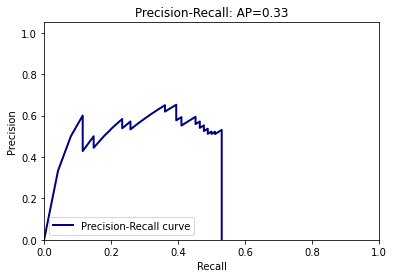

IoU threshold set to: 0.95
TP: 6.0
FP: 52.0
FN: 43.0
Avg. overlap for mandatory = 0.9648
Precision for mandatory = 0.1034
Recall for mandatory = 0.1224
AP for mandatory and IoU threshold 0.95 = 0.0219


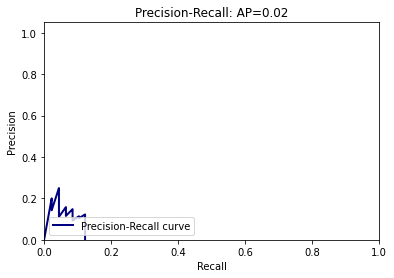

Mean AP for mandatory = 0.7427
IoU threshold set to: 0.50
TP: 59.0
FP: 5.0
FN: 4.0
Avg. overlap for danger = 0.9011
Precision for danger = 0.9219
Recall for danger = 0.9365
AP for danger and IoU threshold 0.50 = 0.9365


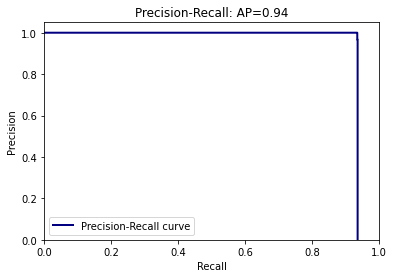

IoU threshold set to: 0.55
TP: 59.0
FP: 5.0
FN: 4.0
Avg. overlap for danger = 0.9011
Precision for danger = 0.9219
Recall for danger = 0.9365
AP for danger and IoU threshold 0.55 = 0.9365


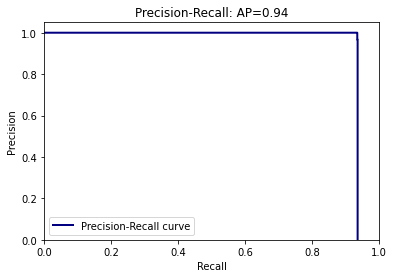

IoU threshold set to: 0.60
TP: 59.0
FP: 5.0
FN: 4.0
Avg. overlap for danger = 0.9011
Precision for danger = 0.9219
Recall for danger = 0.9365
AP for danger and IoU threshold 0.60 = 0.9365


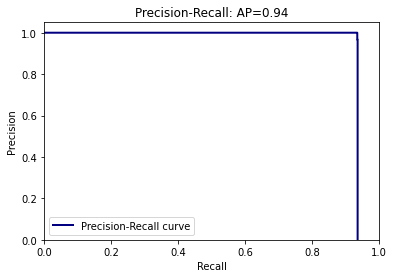

IoU threshold set to: 0.65
TP: 59.0
FP: 5.0
FN: 4.0
Avg. overlap for danger = 0.9011
Precision for danger = 0.9219
Recall for danger = 0.9365
AP for danger and IoU threshold 0.65 = 0.9365


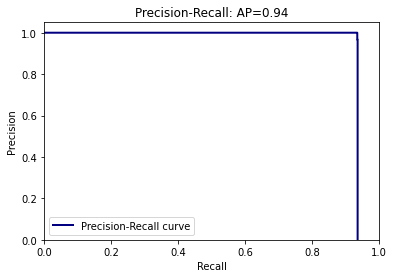

IoU threshold set to: 0.70
TP: 57.0
FP: 7.0
FN: 6.0
Avg. overlap for danger = 0.9086
Precision for danger = 0.8906
Recall for danger = 0.9048
AP for danger and IoU threshold 0.70 = 0.9031


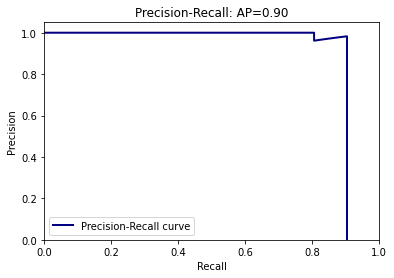

IoU threshold set to: 0.75
TP: 57.0
FP: 7.0
FN: 6.0
Avg. overlap for danger = 0.9086
Precision for danger = 0.8906
Recall for danger = 0.9048
AP for danger and IoU threshold 0.75 = 0.9031


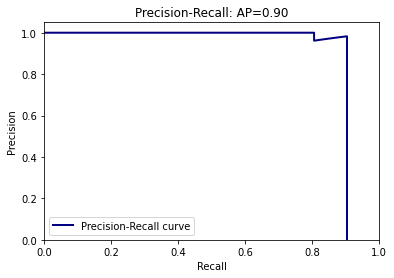

IoU threshold set to: 0.80
TP: 56.0
FP: 8.0
FN: 7.0
Avg. overlap for danger = 0.9108
Precision for danger = 0.8750
Recall for danger = 0.8889
AP for danger and IoU threshold 0.80 = 0.8870


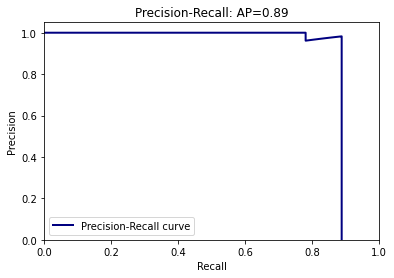

IoU threshold set to: 0.85
TP: 53.0
FP: 11.0
FN: 10.0
Avg. overlap for danger = 0.9150
Precision for danger = 0.8281
Recall for danger = 0.8413
AP for danger and IoU threshold 0.85 = 0.8183


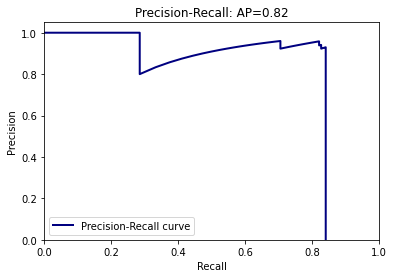

IoU threshold set to: 0.90
TP: 33.0
FP: 31.0
FN: 30.0
Avg. overlap for danger = 0.9370
Precision for danger = 0.5156
Recall for danger = 0.5238
AP for danger and IoU threshold 0.90 = 0.3513


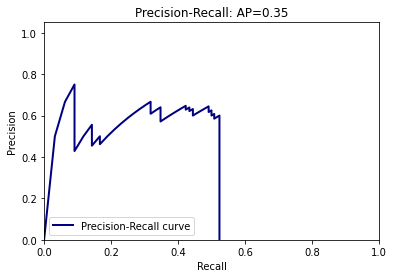

IoU threshold set to: 0.95
TP: 10.0
FP: 54.0
FN: 53.0
Avg. overlap for danger = 0.9652
Precision for danger = 0.1562
Recall for danger = 0.1587
AP for danger and IoU threshold 0.95 = 0.0441


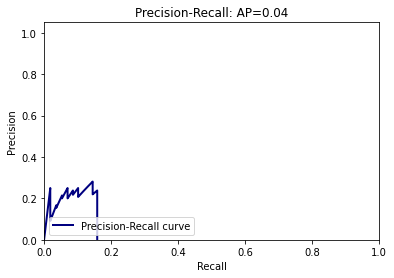

Mean AP for danger = 0.7653
Mean AP = 0.7878
~~~~~~~~
Results:
0.856
0.743
0.765
0.788


0.7878477707951

In [ ]:
compute_mean_average_precision_COCO2016(detections)

In [ ]:
sample = get_detection_by_filename(detections, '00780.jpg')
sample

{'confidences': [0.99999857, 0.999998, 0.99999404, 0.9999119],
 'file': '00780.jpg',
 'file_path': '/media/arcos/Shared/Datasets/GermanTSDataset/Detection/00780.jpg',
 'gt_bboxes': [(365, 468, 466, 558),
  (1165, 572, 1227, 636),
  (1142, 487, 1237, 575),
  (380, 557, 444, 621)],
 'gt_classes': [3, 1, 3, 1],
 'pred_bboxes': [(1146.9669342041016,
   490.3751850128174,
   1232.6372385025024,
   577.7335166931152),
  (367.6278614997864,
   465.81292152404785,
   463.3562159538269,
   561.7812633514404),
  (1166.3718748092651, 575.062894821167, 1228.3914375305176, 637.766170501709),
  (381.5079998970032,
   557.7128887176514,
   444.7719097137451,
   620.1675891876221)],
 'pred_classes': [3, 3, 1, 1]}

FileNotFoundError: ignored

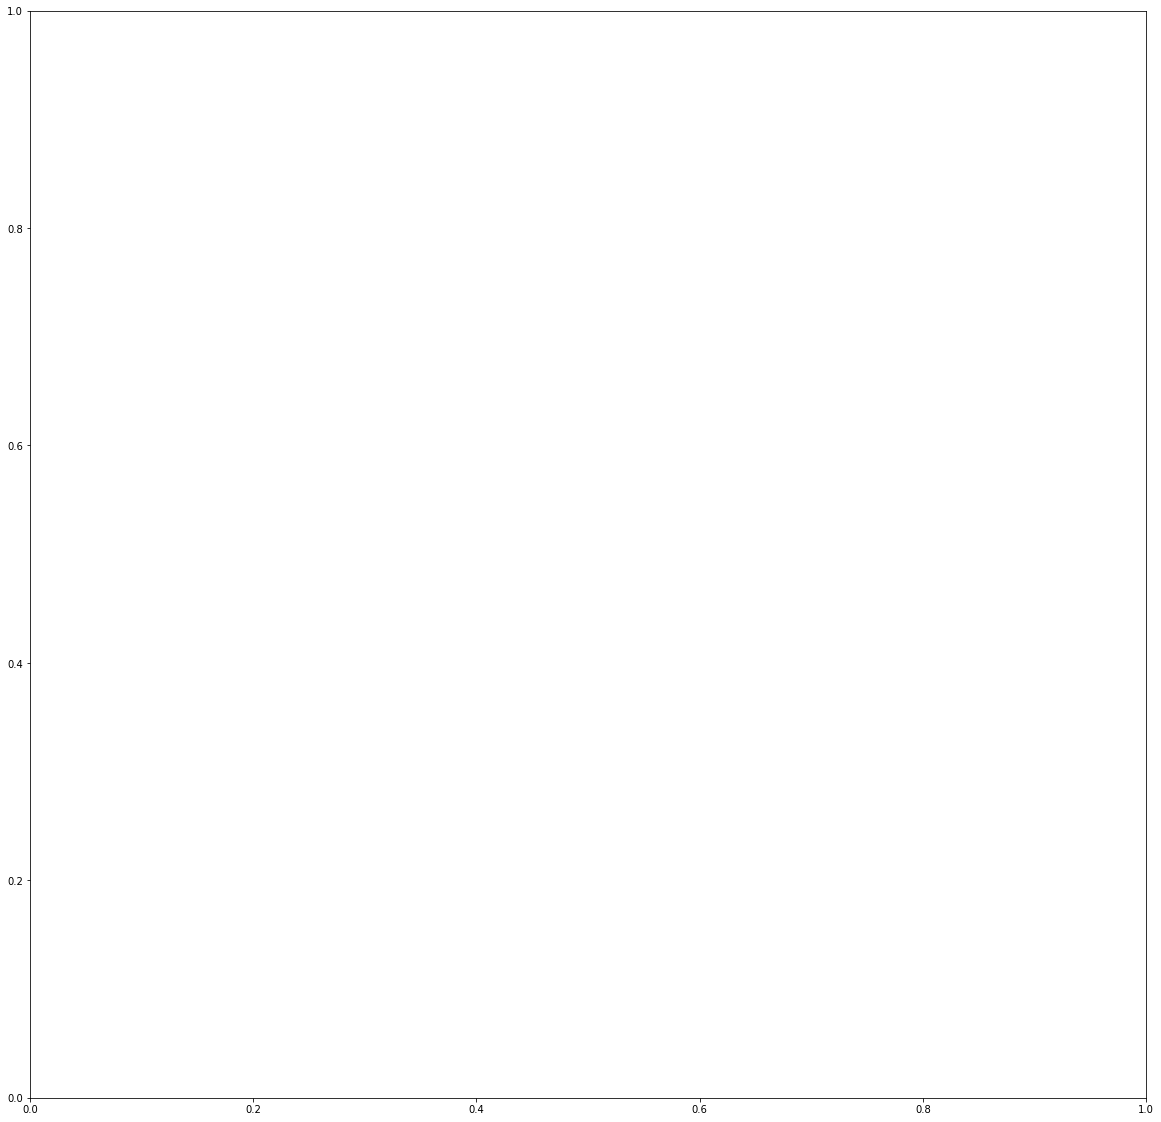

In [ ]:
plot_dets(sample, MODEL_NAME)